In [5]:
#| default_exp learner

In [1]:
#|export
import math, torch, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy

from torch import optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F

from miniai.conv import *
from miniai.training import *

from fastprogress import progress_bar, master_bar

In [7]:
#|export
from contextlib import contextmanager

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

from torch import nn, tensor
from datasets import load_dataset, load_dataset_builder
from miniai.datasets import *
import logging
from fastcore.test import test_close

In [9]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [10]:
logging.disable(logging.WARNING)

##### Quick look into fascore store_attr()

`store_attr` uses `sys._getframe(1)` to get the attributes of the calling funciton. With `sys._getframe(1).f_code` to extract the name of the calling function (passing 0 for the presentframe, 1 for the previous frame, etc) and attributes with `sys._getframe(1).f_code.co_varnames`

A few examples:

In [11]:
import fastcore.all as fc

In [7]:
fc.store_attr??

In [8]:
def whoami():
    import sys
    return sys._getframe(0).f_code.co_name

In [9]:
me = whoami()

In [10]:
me

'whoami'

In [11]:
class Test():
    def __init__(self):
        print(self.whoami())
        self.ok = self.whoami()
        
    @classmethod
    def whoami(self):
        import sys
        return sys._getframe(1)#.f_code.co_name

me  = Test()

<frame at 0x7fdc040162a0, file '/tmp/ipykernel_150/1935095476.py', line 3, code __init__>


In [10]:
me.ok.f_code.co_varnames

('self',)

In [11]:
getattr(me.ok, 'f_code')

<code object __init__ at 0x7f09d7cda810, file "/tmp/ipykernel_107/1935095476.py", line 2>

In [12]:
me.ok.f_locals

{'self': <__main__.Test at 0x7f09d7c2b070>}

##### Details in DataLoaders and collate_dict

In [12]:
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
        
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, num_workers=4, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [8]:
get_dls??

In [118]:
collate_dict??

In [114]:
default_collate??

In [13]:
from operator import itemgetter

In [9]:
d = {'a':1, 'b':2, 'c':3, 'g':10, 'u':-1}

In [10]:
feat = list(d.keys())[2:5]

In [127]:
get = itemgetter(*feat)
get(d)

(3, 10, -1)

In [126]:
get = itemgetter(*d)
get(d)

(1, 2, 3, 10, -1)

#### Learner

In [14]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name) # dataset dict

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [16]:
torch.flatten(TF.to_tensor(dsd['train'][0][x])).shape

torch.Size([784])

In [17]:
bs = 1024
tds = dsd.with_transform(transformi) # transformed dataset

In [18]:
dls = DataLoaders.from_dd(tds, bs) # dataloaders
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:5]

(torch.Size([1024, 784]), tensor([9, 0, 0, 3, 0]))

In [1]:
# class Learner:
#     def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    
#     def one_batch(self):
#         self.xb,self.yb = to_device(self.batch)
#         self.preds = model(self.xb)
#         self.loss = self.loss_func(self.preds, self.yb)
#         if self.model.training:
#             self.loss.backward()
#             self.opt.step()
#             self.opt.zero_grad()
#         with torch.no_grad(): self.calc_stats()
                            
#     def calc_stats(self):
#         acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
#         self.accs.append(acc)
#         n = len(self.xb)
#         self.losses.append(self.loss*n)
#         self.ns.append(n)
        
#     def one_epoch(self, train):
#         self.model.training = train
#         dl = self.dls.train if train else self.dls.valid
#         for self.num, self.batch in enumerate(dl): self.one_batch()
#         n = sum(self.ns)
#         print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)

#     def fit(self, n_epochs):
#         self.accs, self.losses, self.ns = [], [], []
#         self.model.to(def_device)
#         self.opt = self.opt_func(self.model.parameters(), self.lr)
#         self.n_epoch = n_epochs
#         for self.epoch in range(n_epochs):
#             self.one_epoch(True)
#             self.one_epoch(False)    

In [20]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10))

In [17]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.1852192708333333 0.59565
0 False 1.1349698660714285 0.6088142857142858


In [18]:
torch.cuda.is_available()

True

#### Trying the architecture with decorators:

In [21]:
import time

The `CancelCustomException(Exceptions)`s are used to control the flow of the program and to only catch passing flags that are raised in the callbacks when a section of the learner's steps should not run. <br> 
So the `try`/`except` and custom `Exceptions` are a smart but unusual way to interact dynamically with the execution of the Learner.

In [22]:
class CancelKeygenException(Exception): pass
class CancelStatusException(Exception): pass

The try/except and callbacks calls are hidden inside the decorator:

In [23]:
class Capsule():
    def __init__(self, name): 
        self.name = name
        
    def __call__(self, f):
        def _f(o, *args):
            try:
                print(f'- I am inside a {self.name} capsule -')
                o.run_capsules(f'{self.name}_')
                f(o, *args)
            except globals()[f'Cancel{self.name.title()}Exception']: pass
        return _f

In [24]:
class Monitor():
    def keygen_(self):
        print('I divide the key by 10:')
        self.caller._key /= 10
        print(f'Key: {self.caller._key}')

In [25]:
class Descriptor():
    def status_(self):
        print(f'About to decode with key {self.caller._key}')
        for i in range(3):
            time.sleep(0.5)
            print('.')
        print('Here:')

In [36]:
class Builder():
    def __init__(self, seq, key, capsules):
        self.seq = seq
        self._key = key
        self.capsules = capsules
        for c in capsules:
            c.caller = self
    
    @Capsule('keygen')
    def _decode(self, x):
#         import pdb; pdb.set_trace()
        self.val = (self.seq*self._key/x).sum()
    
    @Capsule('status')
    def status(self, x):
        self._decode(x)
        print(f'Value: {self.val}')
    
    def run_capsules(self, name): 
        for c in self.capsules: 
            method = getattr(c, name, None)  
            if method is not None: method()

The use `getattr(c, name, identity)()` garanties that if the attribute name exists it will be found but if not, it defaults to None, so no Error `AttributeError` will be raised.

In [37]:
seq = [1,4,5,4,6,7,8,4,5,1,1,2,6,5,4,9,8,7,5,6,6,5,4,1,3,5,4,5,6,5]
build = Builder(tensor(seq), 3, [Monitor(), Descriptor()])

In [38]:
build.status(150)

- I am inside a status capsule -
About to decode with key 3
.
.
.
Here:
- I am inside a keygen capsule -
I divide the key by 10:
Key: 0.3
Value: 0.2840000092983246


So the architecture of the flexible learner revolves around :
- the use of Callbacks to execute custom code
- control flow with try/except and custom Exception flags
- decorators or context managers that contain the versatile mecanics and keep the code light

#### Trying the architecture with context managers:

In [23]:
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

In [24]:
dls = DataLoaders.from_dd(tds, bs) # dataloaders
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:5]

(torch.Size([1024, 784]), tensor([6, 0, 9, 7, 4]))

In [25]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [26]:
#|export
def run_cbs(cbs, method_nm):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method()

In [27]:
#|export
class Callback(): order = 0

In [29]:
class CompletionCB(Callback):
    def before_fit(self): self.count = 0
    def after_batch(self): self.count += 1
    def after_fit(self): print(f'Completed {self.count} batches')

In [45]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


Frist step before the use context managers:

In [30]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn = self
            
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
        
    def callback(self, method_nm): run_cbs(self.cbs, method_nm)

In [31]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh, 10)))

In [48]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])

In [49]:
learn.fit(1)

Completed 64 batches


In [32]:
#|export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self): raise CancelEpochException()

In [51]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])

In [52]:
learn.fit(1)

Completed 2 batches


#### Metrics

The Metric class will by default calculate the weighted sum of all the added values:

In [33]:
class Metric():
    def __init__(self): 
        self.reset()
        
    def reset(self): 
        self.vals = []
        self.ns = []
        
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    def calc(self, inps, targs):
        return inps

In [54]:
metric_0 = Metric()
metric_0.add(10, n=5)
metric_0.add(15, n=3)
metric_0.add(3, n=1)
metric_0.add(17, n=10)
metric_0.value, round((10*5 + 15*3 + 3*1 + 17*10)/(5+3+1+10),2)

(tensor(14.11), 14.11)

In [34]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [35]:
class EvenCount(Metric):
    def calc(self, inp, targ=None): return 1 if inp%2==0 else 0

In [57]:
seq = [5,1,2,4,6,7,8,4,5,1,3,5,9,8,7,7,4,5,1,3,2,1,3,5,6,8,4,5,4,63,2,1,85,4,8,5,4,65,2,1,5,6,5,1,5]

counter = EvenCount()

def run(seq, metr):
    for i in seq:
        metr.add(i)

In [58]:
run(seq, counter)

In [59]:
counter.vals[:3]

[0, 0, 1]

In [60]:
counter.value

tensor(0.40)

#### Other useful callbacks

In [36]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self): self.learn.model.to(self.device)
    def before_batch(self): self.learn.batch = to_device(self.learn.batch, device=self.device)

In [62]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), CompletionCB()])

In [63]:
learn.fit(1)

Completed 64 batches


We can use the torcheval module with many metrics already implemented, instead of `add` torcheval uses `update`, and `calc` is `compute`:

In [37]:
#|export
from torcheval.metrics import MulticlassAccuracy, Mean

In [38]:
metric = MulticlassAccuracy()
metric.update(tensor([1,3,4,5]), tensor([1,5,8,5]))
metric.compute()

tensor(0.50)

In [73]:
metric.reset()
metric.compute()

tensor(nan)

In [72]:
MulticlassAccuracy??

In [39]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(v) for v in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [40]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
            
    def _log(self, d): print(d)
    def before_fit(self): self.learn.metrics = self
    def before_epoch(self): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = self.learn.epoch
        log['train'] = self.learn.model.training
        self._log(log)
        
    def after_batch(self):
        x,y = to_cpu(self.learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(self.learn.preds), y)
        self.loss.update(to_cpu(self.learn.loss), weight=len(x))

In [99]:
model = get_model()
metrics = MetricsCB(MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'MulticlassAccuracy': '0.607', 'loss': '1.149', 'epoch': 0, 'train': True}
{'MulticlassAccuracy': '0.707', 'loss': '0.796', 'epoch': 0, 'train': False}


In [49]:
#|export
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        for cb in cbs: cb.learn = self
            
    @contextmanager
    def cbs_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')  
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cbs_ctx('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.cbs_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
                        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        with self.cbs_ctx('fit'):
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm)

We can see that the learner is now more compact, and there are new methods that are not defined in the class, `predict`, `get_loss`, `backward`, `step`, `zero_grad`. <br>
These methods are not defined inside the class to allow for more flexibility, we'll use the same mechanism as with the other callbacks to run the code sections that we need.<br> 
First we need customize the `__getattr__` method to redirect the call to a callback containing the method's name, then we need to write a callback that contains these methods, such as the following:

In [42]:
#|export
class TrainCB(Callback):
    def predict(self): self.learn.preds = self.learn.model(self.learn.batch[0])
    def get_loss(self): self.learn.loss = self.learn.loss_func(self.learn.preds, self.learn.batch[1])
    def backward(self): self.learn.loss.backward()
    def step(self): self.learn.opt.step()
    def zero_grad(self): self.learn.opt.zero_grad()

In [43]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self):
        self.learn.epochs = self.mbar = master_bar(self.learn.epochs)
        if hasattr(self.learn, 'metrics'): self.learn.metrics._log = self._log
        self.losses = []
    def _log(self, d): self.mbar.write(str(d))
    def before_epoch(self): self.learn.dl = progress_bar(self.learn.dl, leave=False, parent=self.mbar)
    def after_batch(self):
        self.learn.dl.comment = f'{self.learn.loss:.3f}'
        if self.plot and hasattr(self.learn, 'metrics') and self.learn.model.training:
            self.losses.append(self.learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [97]:
# master_bar??

In [98]:
model = get_model()

In [99]:
# cbs[0].get_loss??

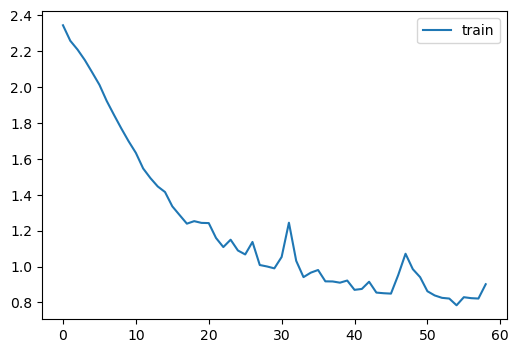

In [58]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

We can also choose to not use callbacks for the structural methods `predict`, `get_loss`, `backward`, `step`, `zero_grad` but subclass the Learner and define these methods then.

### Learner subclasses

In [44]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

We can implement momentum by simply changing zero_grad: instead of zeroing out the gradients, we can just multiply the gradients by a weight smaller than 1 (to lower a bit the previous gradient contributions) to average out directional components that don't align with the most efficient direction to lower the error. 

In [45]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)
        
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

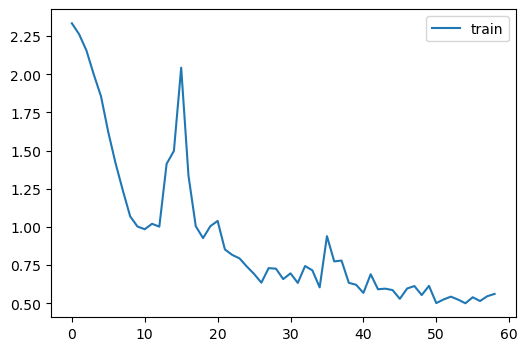

In [47]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

#### LRFinderCB

In [101]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
        
    def before_fit(self):
        self.lrs, self.losses = [],[]
        self.min = math.inf
    
    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult
    
    def plot(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [102]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)                    

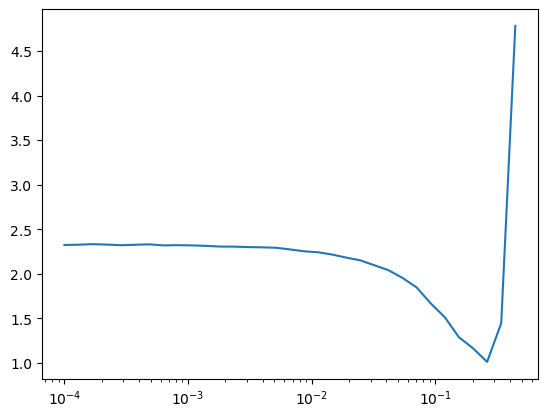

In [103]:
lrfind.plot()

We can use an LR scheduler from Pytorch, it replaces the action of this line of code: <br> 
`for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult` 

In [104]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

In [1]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self):
        self.sched = ExponentialLR(self.learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self):
        if not self.learn.model.training: raise CancelEpochException()
        self.lrs.append(self.learn.opt.param_groups[0]['lr'])
        loss = to_cpu(self.learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

NameError: name 'Callback' is not defined

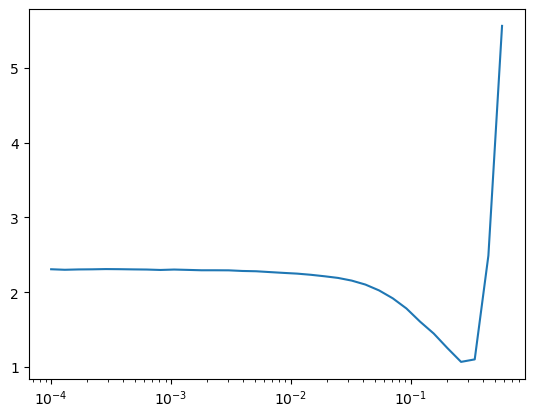

In [106]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)                    

#### Export

In [2]:
import nbdev; nbdev.nbdev_export()